**Goal:** To build a predictive model to predict the winning probability of teams during the next match of IPL Season 2017. We will train the model on all matches before Qualifier-1, validate the model on the Qualifier-1 match between Raising Pune Supergiants and Mumbai Indians and _test_ the model on Qualifier-2 between Kolkata Knight Riders and Mumbai Indians.

Since the predictability of winning a match in Season 2017 depends mainly on the compositions of the teams and their performances in Season 2017, we will consider only the Season 2017's data. 

In [521]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

In [522]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/ipl/"
match= pd.read_csv(data_path+"matches.csv")
score= pd.read_csv(data_path+"deliveries.csv")

In [523]:
match_df=match[(match['season']==2017) & (match['dl_applied']==0)]
match_df.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


Since "id" from "match_df" and match_id from score_df are common columns, we can join "season" with score_df to subset for delivary level data from Season 2017

In [524]:
score_df=score.merge(match_df[['id','season','winner']],left_on='match_id',right_on='id', how='inner')
score_df.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,id,season,winner
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad


Now we need to think about the features that are required to build the model. To get started, will list the features in 2 different sets i.e. features that are important and features that are good to add. We can change them as we keep analyzing.

1. Runs scored in a given over
2. Wickets taken in a given over
3. Cumulative score by each over
4. Cumulative wickets taken by each over
5. Target that the team is chasing down
6. Remaining target by each over
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary response variable wheather the team batting first won the match or the team batting second.

In [525]:
# Runs scored and wickets taken per over #
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].ix[score_df['player_dismissed'] != 0] = 1
train_df=score_df.groupby(['match_id','inning','over','batting_team','bowling_team','winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns=[['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over']]
# Cumulative score and cumulative wickets taken by each over
train_df['innings_wickets'] = train_df.groupby(['match_id', 'innings'])['wkts_over'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'innings'])['runs_over'].cumsum()

# Target that the team is chasing down. if first innings, target is -1#
score_inning1=train_df.groupby(['match_id','innings','batting_team','bowling_team'])['runs_over'].sum().reset_index()
score_inning1['innings']=np.where(score_inning1['innings']==1,2,1)
train_df=train_df.merge(score_inning1,how='left',on=['match_id', 'innings'])
train_df=train_df.drop(['batting_team_y', 'bowling_team_y'],axis=1)
train_df.columns=['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over','innings_wkts','innings_runs','target']
first_innings_index = train_df[train_df.loc[:,'innings'] == 1].index
train_df.loc[first_innings_index, "target"] = -1

# Remaining target that the team is chasing down. if first innings, remaining target is -1#
train_df['remaining_target']=train_df['target']-train_df['innings_runs']
train_df.loc[first_innings_index, "remaining_target"] = -1

#Run rate
train_df['run_rate']=train_df['innings_runs']/train_df['over']

# Required run rate. If first innings, required run rate is -1. If 20th over, equired run rate is 99 #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

#Difference in run rate and required run rate. If first innings, it is -1#
def get_rr_diff(row):
    if row['innings'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)

train_df['is_batting_winner'] = (train_df['batting_team'] == train_df['winner']).astype('int')
train_df.head(2)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wkts,innings_runs,target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_winner
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.0,-1.0,-1.0,1
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.5,-1.0,-1.0,1


### Splitting training and test data

We will train Xgboost model using all the matches till Qualifier-1 match(match_id: 56) between Rising Pune Supergiant and Mumbai Indians and test the model predicting the result of Qualifier-1 match. For this purpose let us seperate the the data set into train and test.

Here the set of features we are using to train the model are:

1. innings 
2. over
3. runs_over
4. wkts_over
5. innings_wkts
6. innings_runs
7. target
8. remaining_target
9. run_rate
10. required_run_rate
11. runrate_diff

And the response/target variable is: is_batting_winner

In [526]:
#Choose all predictors except target
test= train_df.ix[train_df.match_id == 56,:]
train= train_df.ix[train_df.match_id <= 56,:]
predictors = ['innings', 'over', 'runs_over', 'wkts_over', 'innings_wkts', 'innings_runs', 'target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff']
response='is_batting_winner'

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Define a functions for building Xgboost model and cross-validation

This function can be used to train a Xgboost model and predict, run 5-fold cross-validation and also to see the variable importance of features.

In [547]:
# define the function to create the model #
def modelfit(alg,dtrain,dtest,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[response].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[response],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[response].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[response], dtrain_predprob)
    print "n_estimator:", cvresult.shape[0] 
    
    #  Predict on testing data:
    dtest['pred'] = alg.predict(dtest[predictors])
    #results = dtest['response'].merge(dtest[['innings','over','pred']], on=['innings','over'])
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest[response], dtest['pred'])

    imp_df = pd.DataFrame(alg.get_booster().get_fscore().items())
    imp_df.columns=['feature','fscore']
    imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
    imp_df=imp_df.sort_values(by=['fscore'],ascending=False)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
    labels = np.array(imp_df.feature.values)
    ind = np.arange(len(labels))
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,6))
    rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
    ax.set_xticks(ind+((width)/2.))
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_ylabel("Importance score")
    ax.set_title("Variable importance")
    autolabel(rects)
    plt.show()

### Baseline model with initial hyper-parameters

In this model, we will set the values of hyper-parameters to initial values which we thing would give a decent model to set the baseline. Also, let us estimate the number of boosting trees by using cross-validation setting the learning rate to an initial value of 0.1


Model Report
Accuracy : 0.8626
AUC Score (Train): 0.952761
n_estimator: 107
AUC Score (Test): 0.900000


/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


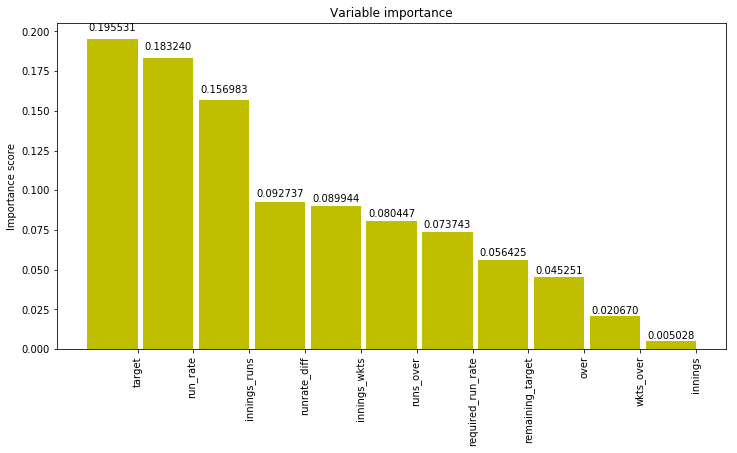

In [548]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, test, predictors)

We can clearly see that target to chase, run rate and cumulative runs scored in the innings are very important in predicting the results of a match while innings and surprisingly wickets taken in a given over are not so important.

The estimated number of boosting trees from cross-validation is 107. So we will set n_estimators to 107 in the next step.

### Hyper-parameter Tuning

Since the order in which hypermeters are tuned needs to be based on their importance in improving the predicting power of the model, we will start with max_depth and min_child_weight. 

#### Grid search for max_depth and min_child_weight

Let us search for the optimal values of max_depth and min_child_weight in 2 steps. First, let us search max_depth between 3 to 10 in steps of 2 and min_child_weight between 1 to 8 in steps of 2.

In [549]:
# Set to n_estimators to the tuned values from cross-validation
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,8,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[response])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67057, std: 0.08830, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.67275, std: 0.09745, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.66481, std: 0.09744, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.66220, std: 0.09522, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: 0.67674, std: 0.08495, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.67054, std: 0.09123, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.66917, std: 0.09183, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.66727, std: 0.09204, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: 0.67999, std: 0.08613, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.66460, std: 0.09405, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.66783, std: 0.09349, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.66827, std: 0.09094, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: 0.67956, std: 0.08758, params: {

Since the optimal values of max_depth is 7 and min_child_weight is 1 from this search, I will search max_depth in [6, 7,8] and min_child_weight in [1,2,3] during next search.

In [550]:
# Set to n_estimators to to the tuned values from cross-validation
param_test1 = {
 'max_depth':[6,7,8],
 'min_child_weight':[1,2,3]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[response])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.67565, std: 0.08809, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.67345, std: 0.09159, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.67091, std: 0.09730, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.67999, std: 0.08613, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.67104, std: 0.09160, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.66460, std: 0.09405, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.67457, std: 0.08696, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.66951, std: 0.08943, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.66617, std: 0.09500, params: {'max_depth': 8, 'min_child_weight': 3}],
 {'max_depth': 7, 'min_child_weight': 1},
 0.6799947292558993)

Here, we get the optimum values as 7 for max_depth and 1 for min_child_weight

### Grid Search for gamma

Gamma can take any value from 0 to positive infinity. Let us check for values if gamma between 0 and 1 to start with.

In [551]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[response])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.67999, std: 0.08613, params: {'gamma': 0.0},
  mean: 0.67747, std: 0.08685, params: {'gamma': 0.1},
  mean: 0.67760, std: 0.08473, params: {'gamma': 0.2},
  mean: 0.67908, std: 0.08531, params: {'gamma': 0.3},
  mean: 0.68137, std: 0.08585, params: {'gamma': 0.4},
  mean: 0.67838, std: 0.08783, params: {'gamma': 0.5},
  mean: 0.67935, std: 0.08472, params: {'gamma': 0.6},
  mean: 0.67871, std: 0.08970, params: {'gamma': 0.7},
  mean: 0.67336, std: 0.08815, params: {'gamma': 0.8},
  mean: 0.67789, std: 0.08964, params: {'gamma': 0.9}],
 {'gamma': 0.4},
 0.6813722331055516)

Gamma: 0.4 is the optimal value. Let us recalibrate the n_estimator based on the tuned parameters.


Model Report
Accuracy : 0.9169
AUC Score (Train): 0.980084
n_estimator: 107
AUC Score (Test): 0.875000


/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


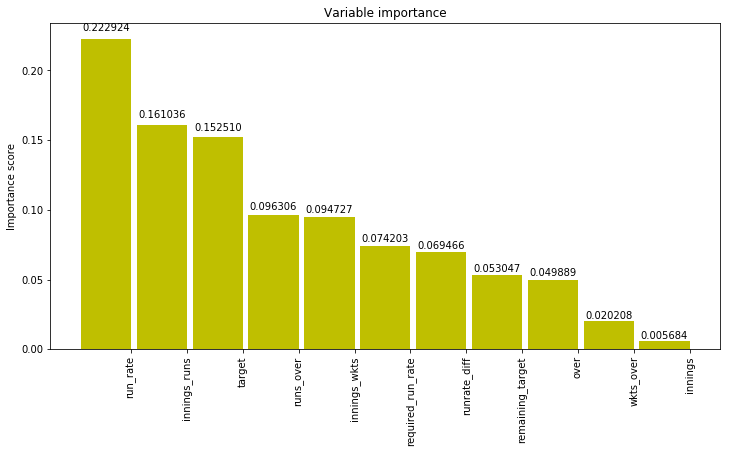

In [553]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=107,
 max_depth=7,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train,test, predictors)

The number of estimated boosting trees remained the same but there is a clear change in variable importance scores if variables. Compared to the baseline model the train auc increased but the test auc decreased which means we are overfitting the model. Let us continue to tune the hyper-parameters and then add regularization to control the overfit.

### Grid Search subsample and colsample_bytree

By setting subsample and colsample_bytree to 1, we are going to train all the trees with all the features and all the training samples. But if we find an optimal values to these hyper-parameters that are less than 1, we will decrease the variance of the model at the cost of adding some bias to the model.

In [558]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=7,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[response])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.67617, std: 0.08760, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.67392, std: 0.08901, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.67560, std: 0.09258, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.67883, std: 0.08940, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.67786, std: 0.08511, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.67636, std: 0.08205, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.67893, std: 0.08478, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.67645, std: 0.08819, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.67495, std: 0.08265, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.67563, std: 0.08613, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.68137, std: 0.08585, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.67547, std: 0.08920, params: {'subsample': 0.9, 'colsample_bytree'

Since colsample_bytree is 0.8 and subsample is 0.8, let us search by 0.05 around these values.

In [559]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,95,5)],
 'colsample_bytree':[i/100.0 for i in range(70,95,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=7,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[response])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.67820, std: 0.08850, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: 0.67893, std: 0.08478, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.67727, std: 0.08505, params: {'subsample': 0.85, 'colsample_bytree': 0.7},
  mean: 0.67645, std: 0.08819, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.67566, std: 0.09051, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: 0.68137, std: 0.08585, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: 0.67616, std: 0.08105, params: {'subsample': 0.85, 'colsample_bytree': 0.75},
  mean: 0.67547, std: 0.08920, params: {'subsample': 0.9, 'colsample_bytree': 0.75},
  mean: 0.67566, std: 0.09051, params: {'subsample': 0.75, 'colsample_bytree': 0.8},
  mean: 0.68137, std: 0.08585, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.67616, std: 0.08105, params: {'subsample': 0.85, 'colsample_bytree': 0.8},
  mean: 0.67547, std: 0.08920, params: {'subsample': 0.9, 'colsamp

Since the mean cv auc values and the standard deviation are same for both (0.8,0.8) and (0.75,0.8), let us chose (0.75,0.8) as that would decrease the correlation between tress.

### Grid Search on regularization parameters

Since the dimensionality of the predictors is low, we don't need L1 regularization but L2 regularization would control overfitting which resulted from tuning some of the hyper-parameters earlier.

In [560]:
param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=107, max_depth=7,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[response])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.68106, std: 0.08945, params: {'reg_lambda': 1e-05},
  mean: 0.68327, std: 0.08407, params: {'reg_lambda': 0.01},
  mean: 0.68202, std: 0.08417, params: {'reg_lambda': 0.1},
  mean: 0.68137, std: 0.08585, params: {'reg_lambda': 1},
  mean: 0.66939, std: 0.09763, params: {'reg_lambda': 100}],
 {'reg_lambda': 0.01},
 0.6832694449291936)


Model Report
Accuracy : 0.9338
AUC Score (Train): 0.987138
n_estimator: 107
AUC Score (Test): 0.950000


/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


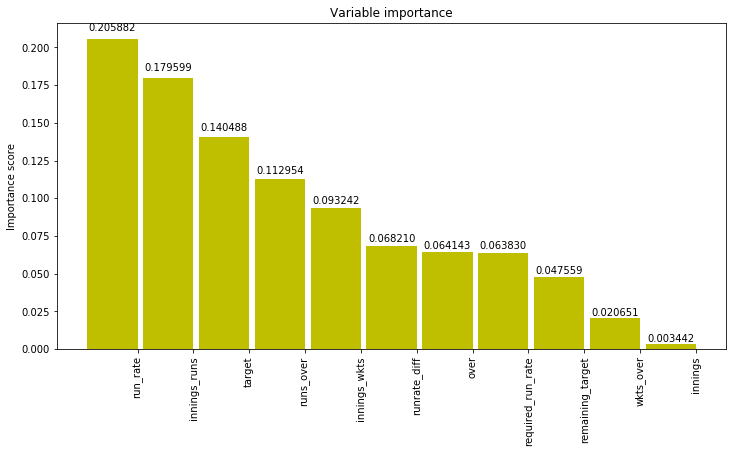

In [561]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=107,
 max_depth=7,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train,test, predictors)

The test auc increased drastically while the training auc increased slightly after L2 regularization. This shows that the overfitting happened earlier has been contorlled.

#### Reduce learning rate and add more trees

Now let us reduce the learning rate and increase the number of trees but this might again lead to overfit.


Model Report
Accuracy : 0.8489
AUC Score (Train): 0.949344
n_estimator: 80
AUC Score (Test): 0.875000


/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


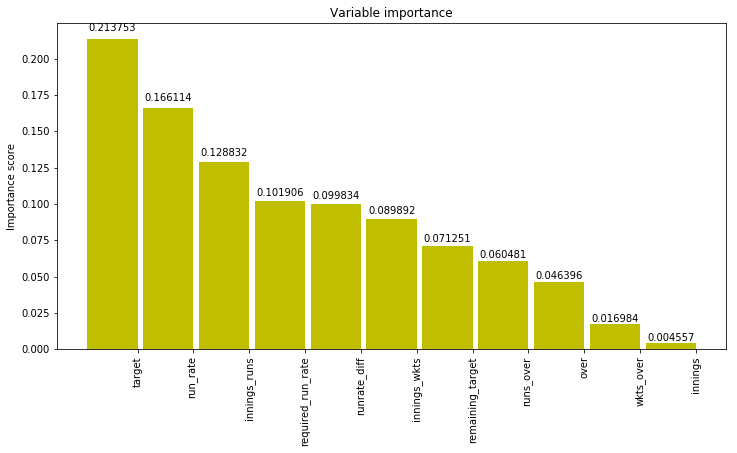

In [566]:
xgb4 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=500,
 max_depth=7,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train,test, predictors)

Reducing the learning rate and increasing the number of trees degraded the model performance as we thought. So let us see what increasing the learning rate and reducing the number of tree does to the model.

#### Increasing learning rate and cutting down trees


Model Report
Accuracy : 0.953
AUC Score (Train): 0.992710
n_estimator: 100
AUC Score (Test): 0.975000


/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


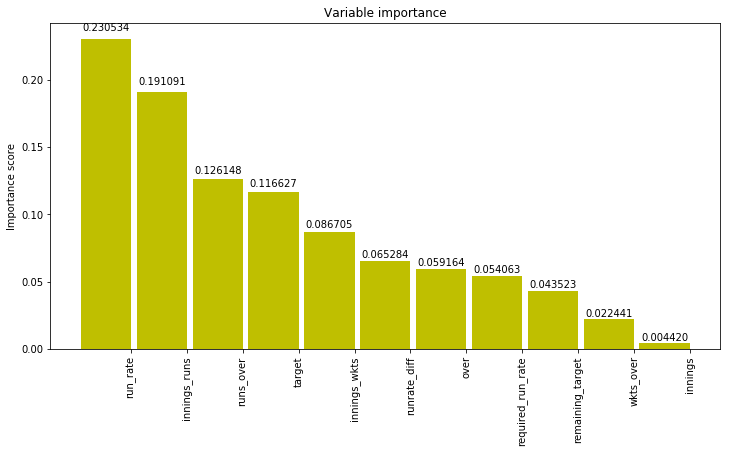

In [575]:
xgb5 = XGBClassifier(
 learning_rate =0.15,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train,test, predictors)

Increasing the learning to 0.15 and cutting down the number of boosting trees to 100 increased the predictive power highly.

In [576]:
# let us build the model and get predcition for the final match #

xgtest = xgb.DMatrix(test[predictors])

preds = xgb5.predict_proba(test[predictors])[:,1]

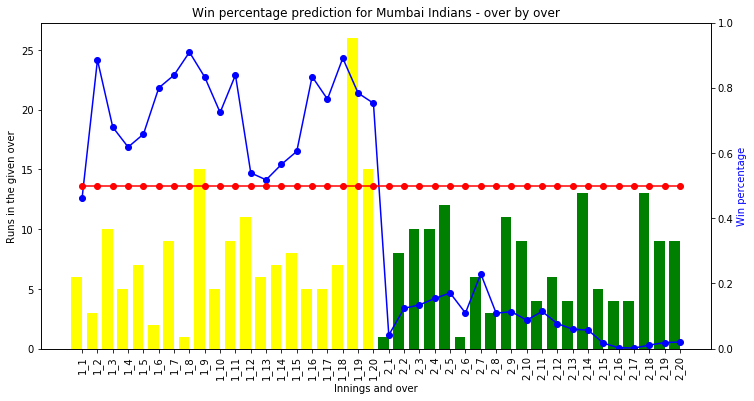

In [577]:
out_df = pd.DataFrame({'Team1':test.batting_team.values})

out_df['innings_over'] = np.array(test.apply(lambda row: str(row['innings']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = test.innings_runs.values
out_df['innings_wickets'] = test.innings_wkts.values
out_df['score_target'] = test.target.values
out_df['total_runs'] = test.runs_over.values
out_df['remaining_target'] = test.remaining_target.values
out_df['predictions'] = list(preds)

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Mumbai Indians - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

**Observations:** The model predicted that Mumbai Indians winning almost at every point during the match which can be clearly seen from the margin of runs with which MI won i.e. 20 run margin in a match with 162 runs target.

### Testing the Model on Qualifier-2

In [599]:
test= train_df.ix[train_df.match_id == 58,:]

In [588]:
# let us build the model and get predcition for the final match #

xgtest = xgb.DMatrix(main_test[predictors])

preds = xgb5.predict_proba(main_test[predictors])[:,1]

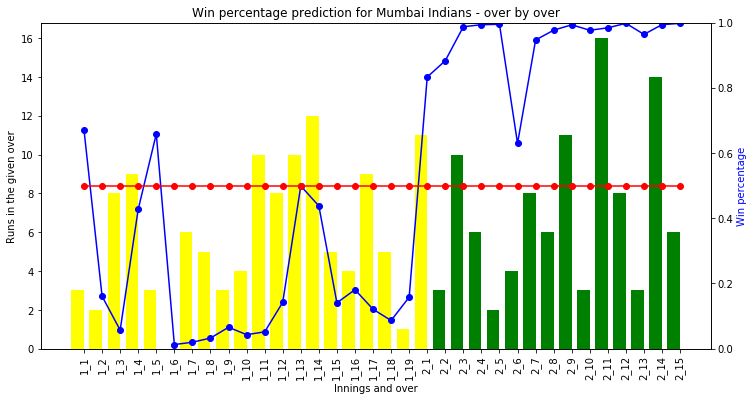

In [598]:
out_df = pd.DataFrame({'Team1':test.batting_team.values})

out_df['innings_over'] = np.array(test.apply(lambda row: str(row['innings']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = test.innings_runs.values
out_df['innings_wickets'] = test.innings_wkts.values
out_df['score_target'] = test.target.values
out_df['total_runs'] = test.runs_over.values
out_df['remaining_target'] = test.remaining_target.values
out_df['predictions'] = list(preds)

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Mumbai Indians - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*34), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

Our model predicted that Mumbai Indians is going to win the match almost at every point during the match. MI actually chased the target in 15 overs and won the match with 6 wickets remaining.